# How to use the NTfit code
### to fit nonuniform temperature distributions from single-beam absorption spectroscopy

This is a multi-step fitting procedure: first you have to fit the spectrum for the $S(E")$, and then do the temperature inversion. It might be helpful to follow along with this box diagram from [Appendix C of the Part II paper](https://arxiv.org/pdf/2011.06638):

<a id='schematic'>![title](ntfit_block_diagram.PNG)</a>

The first Python step is to import necessary code packages. The `ntfit` package can be installed with `pip`, but in this example I'm importing `ntfit` from a sibling directory using `sys.path`.

In [1]:
# built-in modules
import numpy as np
import matplotlib.pyplot as plt
import os

# nonuniform-temperature code
from sys import path as syspath
syspath.append(r'../')
import ntfit.spectrafit as ebin
from ntfit.tdist import Snorm2Tx
plt.rcParams.update({'figure.autolayout':True,'lines.linewidth':0.8}) # plot formatting

HAPI version: 1.1.0.9.6 with power-law lineshape changes


## E"-binning: Extract linestrengths from spectrum

The first box of the [schematic](#schematic) is the spectrum fit. The spectrum fit code is in `spectrafit` module, an implementation of the [Part II paper](https://arxiv.org/pdf/2011.06638). See pages 6-7 of PDF link for some intuition.

To fit a temperature distribution, you will need several inputs:
1. A [spectrum](#1), with x and y arrays
1. A HITRAN [linelist](#2) to model the spectrum
1. [Selection of E"](#3) to split linelist into several different models
1. [Nominal path-average](#4) $T_0$, $P_0$, $\chi_0$, $L$ conditions to simulate an absorption model
1. [Time-domain](#5) (cepstral) fitting conditions

You must initialize the spectrum and linelist, but the other inputs have defaults you can adjust as needed.

It's a lot of inputs to keep track of, and you'll probably want to save all of these inputs alongside your fit output, so you can replicate your work later. That's why `ntfit` stores all of these inputs and outputs in one object.

We'll go through these inputs step by step

*The functions you might want to run generally start with "N.fit" or "N.plot", so when in doubt, type this and then tab to see what's available

In [2]:
file_name = os.path.join(os.getcwd(),'data','example_td')
band_fit = [6802, 7000] # fit region (cm-1)
# 0) Initialize the E"-binning object. 
N = ebin.EbinHapi(file_name + 'new', bandwidth = band_fit)

#### 1) <a id='1'>Add transmission spectrum</a>

`N.x_wvn_full` is the x-array to populate, and `N.trans_spectrum` is the y-array. Here `wvn` indicates wavenumber in $cm^{-1}$, and "trans" is transmission (or non-normalized intensity), where the absorbance is the negative of the natural logarithm of `N.trans_spectrum`.

For this example, I previously created a synthetic spectrum in the ASC file by generating an array of temperatures `N.tx_act_kelvin` and running `N.simulate_spectra()`. I populate the object with these arrays using the `get_transmission_asc()` function:

In [3]:
N.get_transmission_asc(r'data\Furnace_Synth.asc')

This ASC file format also overwrites the default path-average T,P,$\chi$,L. So that's step <a id='4'>4)</a>. Try the `print_thermo()` command to confirm selections

In [4]:
N.print_thermo()

Uniform-path approximations
Temperature =  380.0 Celsius
Pressure =  640.0 Torr
Molefraction =  0.01
Pathlength =  152.4 cm

To change these properties for spectral fitting, 
update self.t_celsius, self.p_torr, self.chi, self.pathlength.
eg. >> N.t_celsius = 500   # (if working with Example_td.py)


Don't worry if you don't know what path-average properties to choose. Although you probably have good independent knowledge of the pressure and pathlength. If your initial-guess temperature or molefraction is very incorrect, you can worry about that [later](#lineshape).

You can also optionally use `N.calc_bkgd()` to subtract any out-of-domain absorption before the fit.
I envision using this if you are measuring combustion in some channel, and you have some background measurement pulling a vacuum in the channel. This background measurement sees only the ambient H$_2$O absorption between the channel walls and the optics. You can fit the path-average T,P,$\chi$,L from this background measurement and pass these as inputs to `calc_bkgd()`. If you don't call `calc_bkgd()`, there is no background subtraction.

#### 2) <a id='2'>Load HITRAN-formatted linelist</a>

In [5]:
# 2) linelist
N.linelist_path = r'linelist/H2O_PaulLF.data' # Hitran-formatted PAR file
                     # must also have .header file of same name to run HAPI

#### 3) <a id='3'>Select E" bins</a>


In [6]:
print('Default E" boundaries: E" =', N.ebin_edges)
N.ebin_edges = [0,200,500,750,1020,1220,1440,1680,1940,2220,2510,2820,3100,7000]
print('Actual E"-bin boundaries: E" =', N.ebin_edges)

Default E" boundaries: E" = [0, 500, 1000, 2000, 7000]
Actual E"-bin boundaries: E" = [0, 200, 500, 750, 1020, 1220, 1440, 1680, 1940, 2220, 2510, 2820, 3100, 7000]



Fitting 13 areas
Filtering first 0.20% of cepstrum from fit
This is 116 points, a 9.8 ps filter
Filtering first 116 points of cepstrum from fit
This is a 9.8 ps filter
Using non-standard HITRAN parameters for:
['delta_self', 'n_self', 'sd_self']
Fit residual is 24.54x noise floor and 5.9% of data
At this weighting-window, signal is 417.6x noise
Fit in 2 seconds


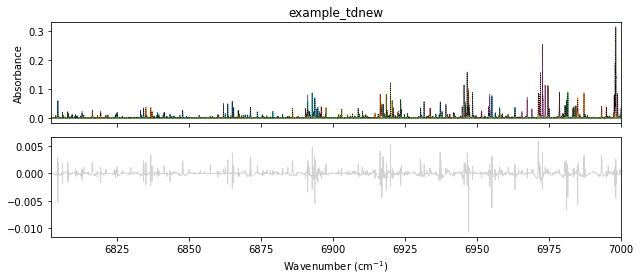

In [7]:
# Now the actual fit
N.fit_snorm();

# output S(E") fit
ebins = N.ebin_xVals # Maybe rename N.elower_avg
snorm = N.snorm_out

The above plot shows the spectrum fit, floating the size of each E"-bin spectral signature.
The bottom plot shows the fit residual $$\alpha_{meas} - \sum\limits{_{i=1}^{E"-bins}} \hat{S}_i \alpha_i$$
Each E"-bin signature is a different color, and the baseline-subtracted measurement is dotted black line. This plot has a lot of traces, and doesn't work well with a legend.

If you want to see the best-fit model for a particular E"-bin, see the below command:

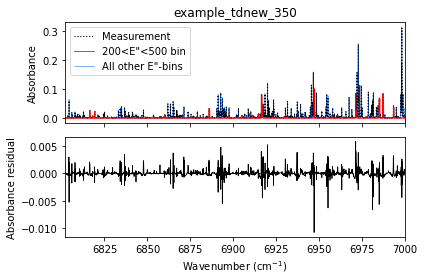

In [8]:
N.plot_ebin(1)

When you pass 1 as the function argument, it plots the best-fit absorbance for all absorption lines in the 2nd E"-bin (because Python is zero-indexed), lines whose E" is between the 2nd and 3rd entries in `N.ebin_edges`.

-------------------------------
At this point, you *can* move on to the [temperature inversion step](#inversion). However, if you see substantial absorbance residual, it's probably worth checking some other diagnostics and repeating the fit with some different conditions.
Before I explain in more detail, 
here are the parameters you might change before re-running `N.fit_snorm()`:
`N.bl`, `N.etalons`, `N.ebin_edges`, `N.wvn_start`, `N.wvn_stop`, `N.t_celsius`, `N.chi`. Or run `N.fit_snorm_width()` or `N.fit_snorm_width_shift()` instead.

#### 5) <a id='5'>Adjust time-domain parameters</a>

The code by default plots spectral fits in frequency-domain, even though the actual least-squares minimization is performed in the [time-domain](https://doi.org/10.1364/OE.27.037920). Time-domain fitting takes the Fourier-transform of the portion of the absorption spectrum with `N.x_wvn` between `N.wvn_start` and `N.wvn_stop`. It then performs a weighted least-squares fit, using a weighting array `N.weight` generated using the `N.bl` and `N.etalons` attributes.

Object attributes with `td` are in the "time-domain", and attributes with `fd` are in the "frequency-domain".

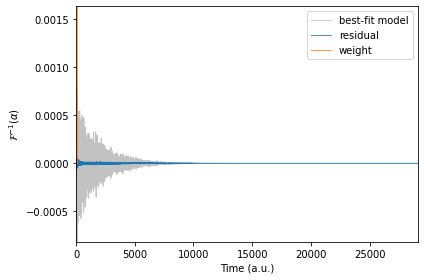

In [9]:
N.plot_td();

This cepstrum has no etalons. Any etalons would be visible as narrow-in-time spikes in residual away from the left side of the plot. You could add notch filters for etalons. For example, setting `N.etalons = [[1000,1010],[2000,2200]]` creates 2 notch filters, the first zero-weighting all x between 1000 and 1010, and the second zero-weighting all x between 2000 and 2200.

If you change `N.bl` or `N.etalons`, you must run `N.get_td()` for the changes to take effect. 

Be careful of the x-axis scaling in the time-domain. By default the x-axis is just an index, for number of points. But the issue with this scaling is that if you change (`N.wvn_stop` - `N.wvn_start`), the etalons shift to a different spot and your filter becomes no good.

To get around this issue, you can define `N.bl` and `N.etalons` in picoseconds, based on the definition of delay in double-sided interferograms for Fourier Transform or Dual-Comb spectroscopy. In this case, use `N.plot_td(True)` to determine the optimal `N.bl` and `N.etalons`, and then apply those changes with `N.get_td(bl_ps=True)`.

<a id='lineshape'>**Optional refinement step**</a>

Also recommend to iterate on the lineshape, to improve the spectral fit and get more accurate normalized linestrengths $\hat{S}(E^{\prime\prime}$). See [section 2.4 of Part II paper](https://arxiv.org/pdf/2011.06638).

This fit is much slower, because width and shift floats are nonlinear. 

<!--The shift fit is particularly unstable, and might not converge unless the normalized linestrengths are already good from ```N.fit_snorm()``` -->

In [10]:
scipy_results3 = N.fit_snorm_width_shift()
plt.close();


Fitting 13 areas, widths, shifts
Jacobian fit in 9.14 seconds
Fit residual is 13.09x noise floor and 3.1% of data
At this weighting-window, signal is 417.6x noise
Spectral fit + cleanup in 11 seconds
64% reduction in chi-squared from initial fit


Now look at the new output arrays generated by the fit.  If you're following along with the [schematic](#schematic), the array $\Gamma (E")$ is `N.p_rat`, and $\Delta (E")$ is `N.shift`, and by default these values are all zeros. The important output array $S (E")$ is `N.snorm_out`

In [11]:
print('\nSnorm(E")',N.snorm_out)
print('Pressure(E")', N.p_rat)
print('Shift(E")', N.shift)
plt.close();


Snorm(E") [1.50883307 1.2131003  1.00232742 0.9072948  0.84407483 0.83056851
 0.83009114 0.85682906 0.89879815 0.97456962 1.08972486 1.23450957
 1.46755292]
Pressure(E") [-1.66035626e-04 -9.19087488e-05 -5.88208785e-05 -2.94322307e-05
 -6.72747185e-06 -6.65343124e-06 -3.22454947e-06 -4.85473316e-06
 -5.25930808e-06 -9.04298866e-06 -1.19078649e-05 -1.42853747e-05
 -1.59819492e-05]
Shift(E") [ 6.58109693e-04  6.61615815e-04  6.72869878e-04  4.40215815e-04
  2.11113103e-04  5.34588129e-05 -3.06347672e-04 -5.99437443e-04
 -8.76303019e-04 -1.28691346e-03 -1.40416054e-03 -1.88275127e-03
 -2.00060307e-03]


You can plot $S(E")$ using `N.fit_temperature()` aka `N.plot_snorm_vs_elower()`.
See [Part II paper](https://arxiv.org/pdf/2011.06638), first paragraph of p. 7, for advice on interpreting the plot. Below is some manual code to make the same plot, so we can compare the fits before/after fitting the lineshape. 

In [12]:
# show change in S(E") due to lineshape-floating
print('Normalized linestrength plot before/after lineshape float')
plt.figure()
plt.plot(ebins, snorm,'+',label='float areas')
plt.plot(N.ebin_xVals, N.snorm_out, 'x', label='float areas, width, shift')
plt.xlabel('Lower-state energy E" (cm$^{-1}$)')
plt.ylabel('Normalized linestrength')
plt.legend()
plt.title('E"-bin output (T$_0$=%d K)'%(N.t_celsius+273));

Normalized linestrength plot before/after lineshape float


Ideally this plot will have several data points along the outline of a smooth curve. In this instance, the data points do fall along a smooth curve for both the original and refined fit iterations. This is because we are fitting synthetic data.

If the data points above have scatter and do not fall along a smooth curve, that is an indication of a poor fit (due to linelist parameter error or high spectral residual). If the uncertainty bars are large, you can combine E"-bins. If the uncertainty bars are smaller than the scatter, you can split some of the E"-bins into multiple bins.

This plot is a parabola around y=1. This means there is temperature nonuniformity, and that the spectral fit was calculated with a model at T,P,$\chi$,L close to the actual path-average. If many of the y-values are far from 1, or there is a substantial slope to the points, then `ntfit` is probably calculating suboptimal lineshapes from [incorrect path-average temperature and molefraction/pressure](#4). Repeating the fit with improved path-average parameters may subtly shift your results in the [inversion](#inversion). You can do this by running `N.fit_temperature(True)`, in which case your `N.p_rat` and `N.shift` reset to 0. If you have no idea what your path-average quantities are, run `N.fit_temperature(True)` before running `N.fit_snorm_width_shift()` for optimal lineshape calculations.

## Temperature inversion: <a id='inversion'>fit temperature distribution</a>
Now that you have some spectral fit parameters from the E"-binning step, you need to determine the most likely temperature distribution. This step is the "temperature inversion", the right box of the [schematic](#schematic), labelled "length-bin with Tikhonov regularization".

If those words don't make sense, this technique is described in the [Part I paper](https://arxiv.org/pdf/2008.01522). Check out section 4 for the intuition and justification, and Appendix D for the specific math.

The temperature inversion happens in a separate Python object, in this case `L`, which inherits the necessary outputs of the E"-bin object `N`.

In [13]:
L = Snorm2Tx(N)
L.reg_weight = 10.**(np.arange(2,-5,-1))
plot_handles = L.length_bin()
#L.save_fit()

Tikhonov regularization in 50 seconds
98 % fit improvement from uniform-fit


The above plot is complicated, with each fit result shown color-coded on the three plots. 

* **Left: Normalized linestrength fits.**
Normalized linestrength curves corresponding to each temperature distribution.
The black dots are the E"-bin normalized linestrength fits from earlier, with uncertainty bars.

* **Middle: Temperature distributions**
The length-bin inversion splits the laser path into several equal-length chunks and finds the temperature of each chunk. The x-axis is just the index of those different equal-length chunks, and the y-axis shows the full allowed temperature fit range.
The fitting algorithm fits a profile with the maximum temperature somewhere towards the middle, whereas this plot shows the corresponding temperature distribution (temperatures sorted ascending), because the spectroscopy is not sensitive to the arrangement of temperature along the path.

* **Right: L-curve**
This is a way to evaluate the temperature distributions to see which the algorithm accepts (bold traces). The x-axis describes the fit residual in the normalized linestrength fit, and the y-axis describes the smoothness of the temperature profile fit (a smaller y-axis value is a smoother profile, where the uniform temperature has y-axis value 0).
The black x-marks are for the least-squares and uniform-temperature fits. If these have a similar x-axis value, then there is little spectroscopy evidence for temperature nonuniformity. Any fits towards the bottom-left corner are plausible temperature distributions. You can adjust ```L.corner_thrsh``` to allow fits farther from that bottom-left corner to be accepted temperature distributions (in bold)

These plots show every fit result, for many regularization parameter values. The bold trace(s) are the accepted output temperature distribution(s). If there are multiple bold traces, you can assume the difference between those traces is an uncertainty range of the temperature distribution fit.

The dotted black line is the non-negative least-squares temperature fit.



Last, you can display just the output temperature distribution

Best-fit temperature array [326. 365. 402. 440. 481. 533. 581. 633. 691. 744. 801. 855. 894. 920.
 933. 935.]
Pxl column density stronger than E"-bin guess by 1.001


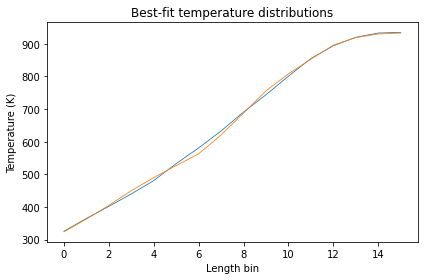

In [14]:
tx_best = np.sort(L.tx[:,L.corner])
pxl_best = L.pxl[L.corner]
print('Best-fit temperature array', tx_best)
print('Pxl column density stronger than E"-bin guess by %.3f' % pxl_best)
plt.figure()
for c in L.corner_all:
    plt.plot(np.sort(L.tx[:,c]))
plt.xlabel('Length bin')
plt.ylabel('Temperature (K)')
plt.title('Best-fit temperature distributions');

In [15]:
## You can also save your fits to reload later
## Automatically save both as N.save_name
## but you can add a suffix
#N.save_fit()
#L.save_fit()
#N.__cleanup__() # empties the E"-bin linelists directory

## can reload these fits later with
# N.load_fit(load_transmission=True, load_path_override = r'data\example_td_ebin')
# L.load_fit_previous(r'data\example_td_tx')